# Spaceship Titanic

## Import the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, cross_val_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score
)
from sklearn.preprocessing import MinMaxScaler
from skrebate import ReliefF
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
from typing import Optional, Tuple
from dataclasses import dataclass

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
submission_data = pd.read_csv('data/sample_submission.csv')

X = train_data.drop(columns='Transported')
y = train_data['Transported']

df = train_data.copy()

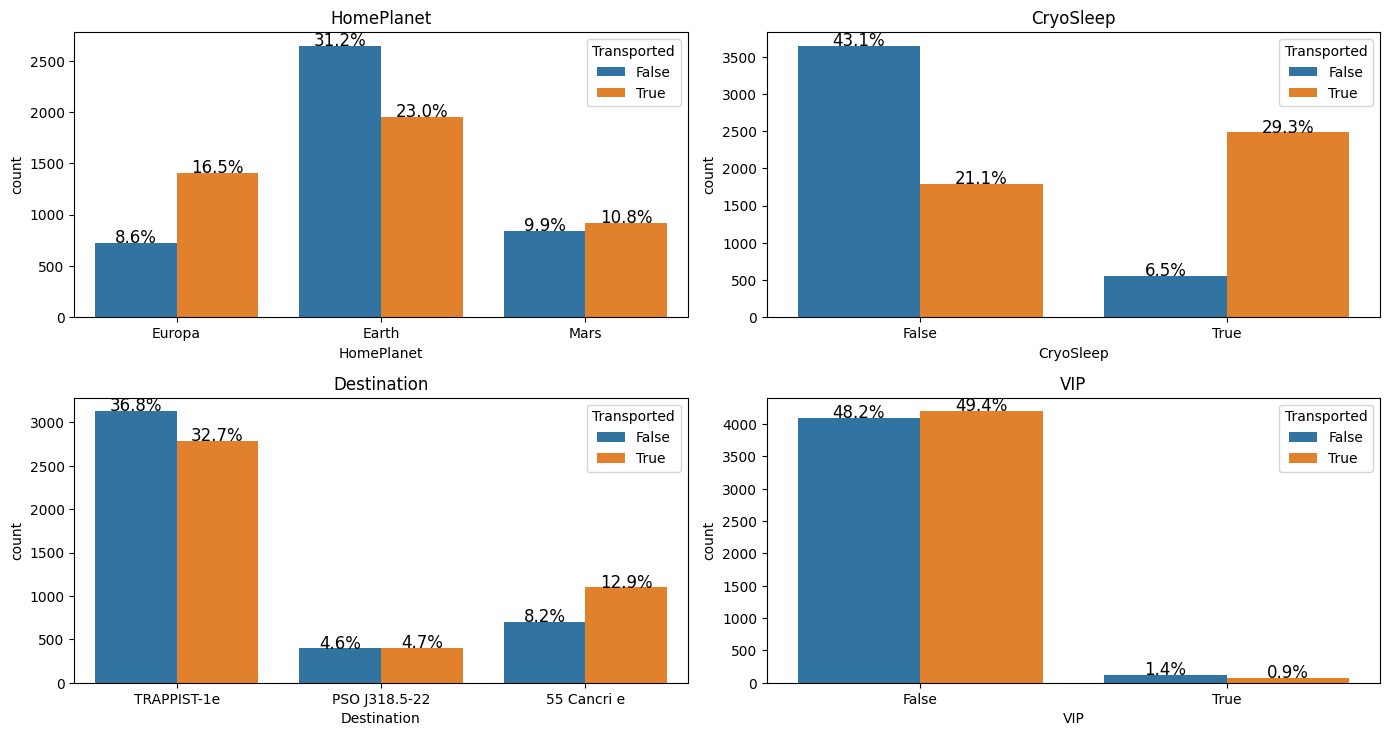

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Categorical features
cat_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig = plt.figure(figsize=(14, 18))
for i, var_name in enumerate(cat_feats):
    ax = fig.add_subplot(5, 2, i + 1)
    plot = sns.countplot(data=df, x=var_name, ax=ax, hue='Transported')

    # Calculate and display percentages
    total_counts = df[var_name].value_counts().sum()
    for p in plot.patches:
        count = p.get_height()
        if count > 0:
            percentage = f'{100 * count / total_counts:.1f}%'
            ax.text(p.get_x() + p.get_width() / 2, count + 2, percentage,
                    ha='center', fontsize=12)

    ax.set_title(var_name)

fig.tight_layout()  # Improves appearance
plt.show()


/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_881/810624828.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0-12' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['Age']<=12,'Age_groups']='0-12'


Text(0.5, 1.0, 'Age group distribution')

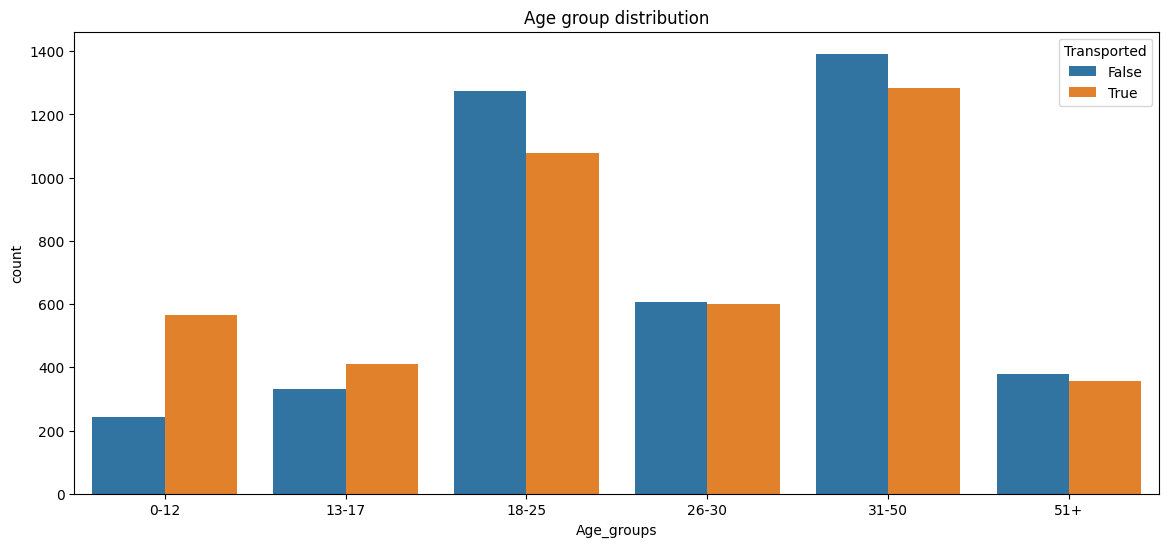

In [7]:
# New features - training set
df['Age_groups']=np.nan
df.loc[df['Age']<=12,'Age_groups']='0-12'
df.loc[(df['Age']>12) & (df['Age']<18),'Age_groups']='13-17'
df.loc[(df['Age']>=18) & (df['Age']<=25),'Age_groups']='18-25'
df.loc[(df['Age']>25) & (df['Age']<=30),'Age_groups']='26-30'
df.loc[(df['Age']>30) & (df['Age']<=50),'Age_groups']='31-50'
df.loc[df['Age']>50,'Age_groups']='51+'

# Plot distribution of new features
plt.figure(figsize=(14,6))
g=sns.countplot(data=df, x='Age_groups', hue='Transported', order=['0-12','13-17','18-25','26-30','31-50','51+'])
plt.title('Age group distribution')

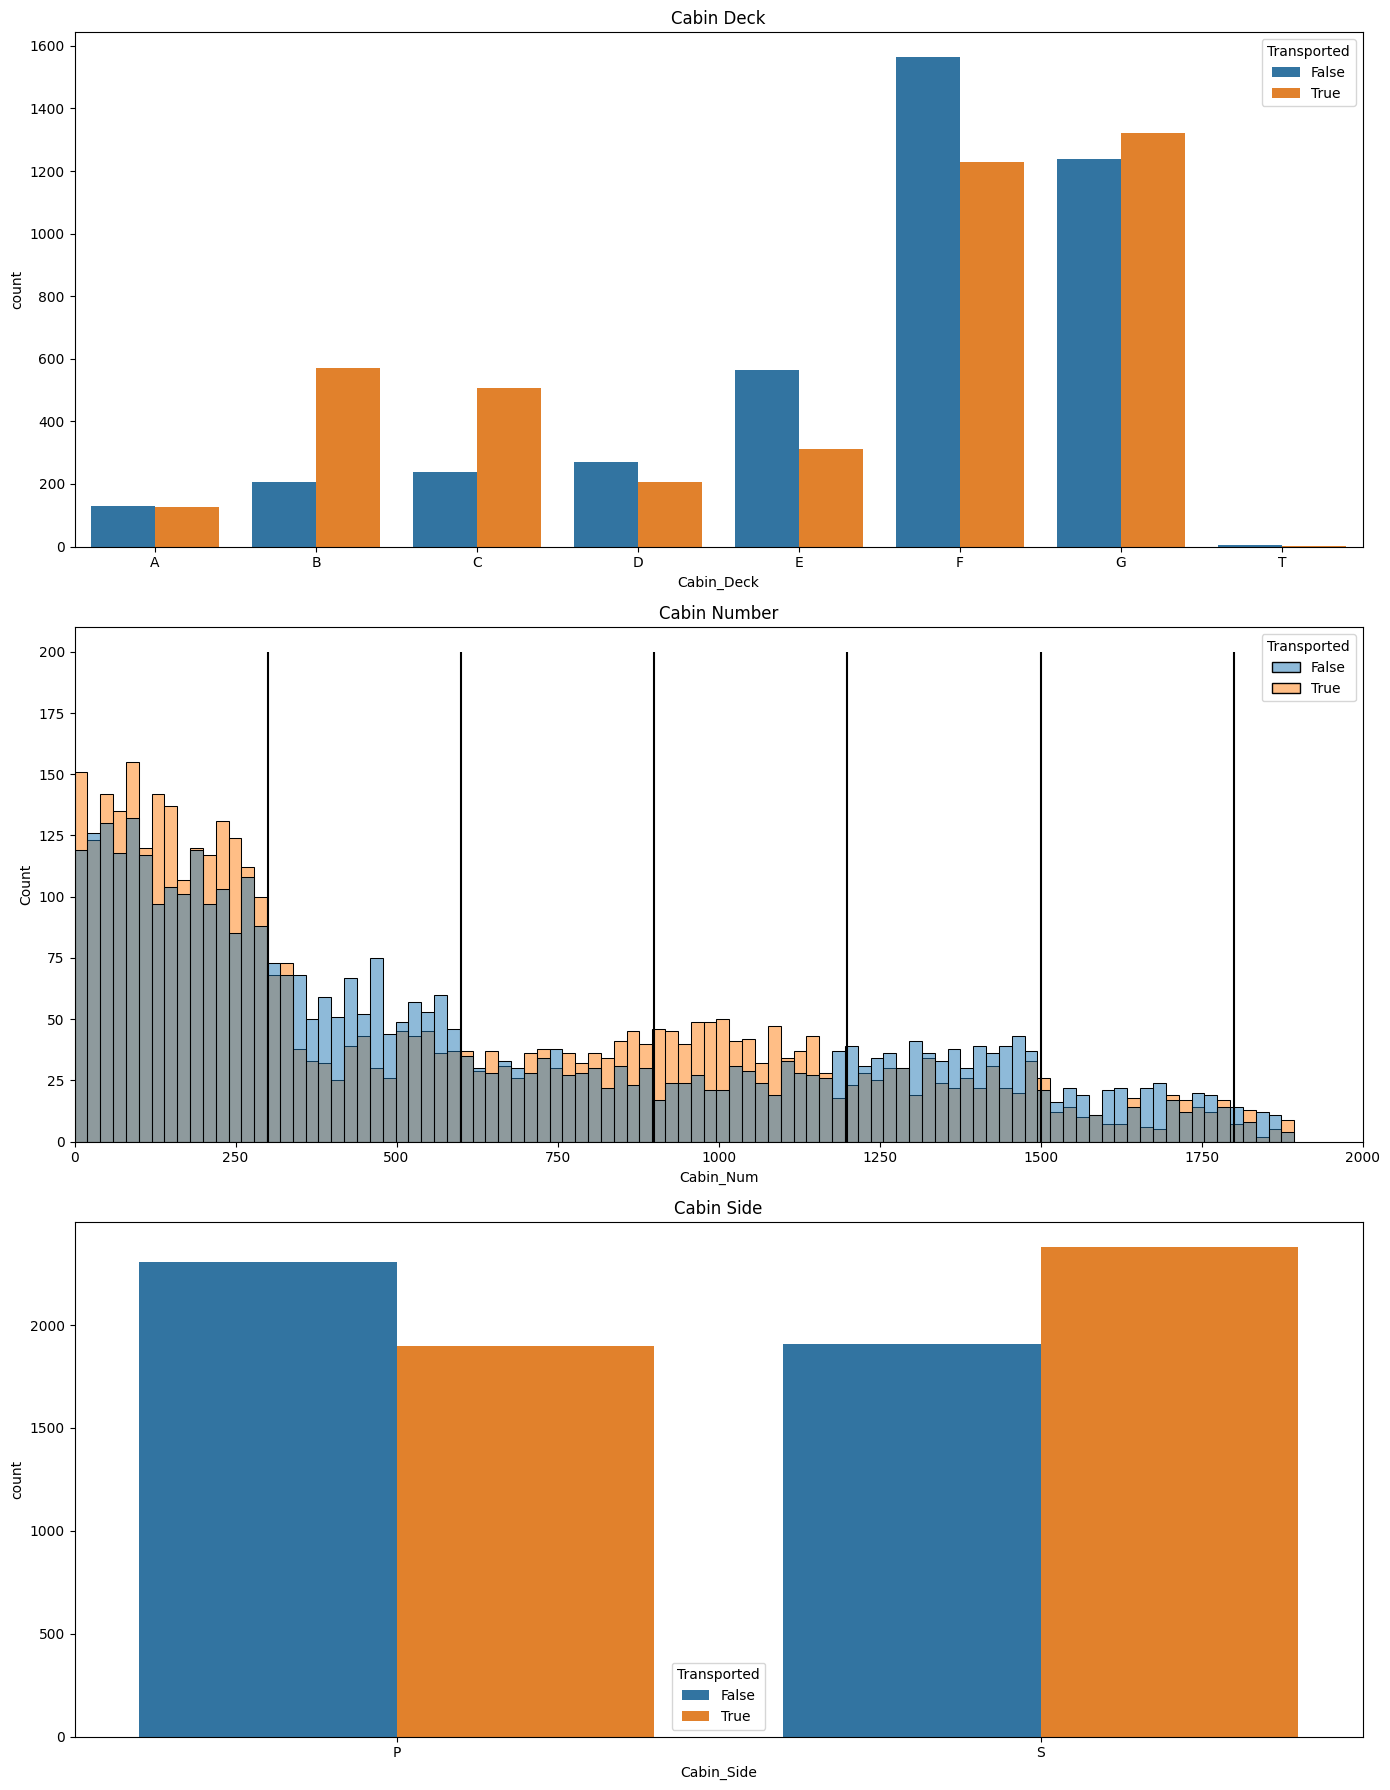

In [6]:
# Replace NaN's with outliers for now (so we can split feature)
# df['Cabin'].fillna('Z/9999/Z', inplace=True)
# df['Cabin'].fillna('Z/9999/Z', inplace=True)

# # New features - training set
# df['Cabin_Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0])
# df['Cabin_Num'] = df['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
# df['Cabin_Side'] = df['Cabin'].apply(lambda x: x.split('/')[2])

# # New features - test set
# # test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
# # test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
# # test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# # Put Nan's back in (we will fill these later)
# df.loc[df['Cabin_Deck']=='Z', 'Cabin_Deck']=np.nan
# df.loc[df['Cabin_Num']==9999, 'Cabin_Num']=np.nan
# df.loc[df['Cabin_Side']=='Z', 'Cabin_Side']=np.nan
# df.loc[df['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
# df.loc[df['Cabin_number']==9999, 'Cabin_number']=np.nan
# df.loc[df['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
# df.drop('Cabin', axis=1, inplace=True)
# test.drop('Cabin', axis=1, inplace=True)

# Plot distribution of new features
fig=plt.figure(figsize=(14,18))
plt.subplot(3,1,1)
sns.countplot(data=df, x='Cabin_Deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin Deck')

plt.subplot(3,1,2)
sns.histplot(data=df, x='Cabin_Num', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin Number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=df, x='Cabin_Side', hue='Transported')
plt.title('Cabin Side')
fig.tight_layout()

In [5]:
df[:10]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


## Exploratory Data Analysis (EDA)

### Visualizing Target Variable

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Transported', palette='viridis')
plt.title('Distribution of Target Variable: Transported')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()

### Missing Values Analysis

In [ ]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

missing_percent = (df.isnull().sum() / len(df)) * 100
plt.figure(figsize=(10, 6))
missing_percent.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()

### Numerical Features Analysis

In [ ]:
numerical_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df[numerical_features].hist(bins=30, figsize=(10, 8), layout=(2, 3), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x=feature, palette='coolwarm')
    plt.title(f'{feature} Outlier Analysis')
plt.tight_layout()
plt.show()

### Categorical Features Analysis

In [ ]:
# in case of "Cabin" we can't understand from the graph
categorical_features = ['HomePlanet', 'Destination', 'VIP']

for feature in categorical_features:
    print(f"Unique values in {feature}: {df[feature].unique()}")

plt.figure(figsize=(12, 8))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=feature, palette='viridis', order=df[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Relationship Analysis

In [ ]:
numerical_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar=True)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

sns.pairplot(df, vars=numerical_features, hue='Transported', palette='viridis', diag_kind='kde', corner=True)
plt.suptitle('Pair Plot of Numerical Features with Transported', y=1.02)
plt.show()

### Feature Interaction

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='CryoSleep', y='RoomService', palette='viridis')
plt.title('RoomService Expenses by CryoSleep Status')
plt.xlabel('CryoSleep')
plt.ylabel('RoomService Expense')
plt.show()

df['TotalExpenses'] = df[numerical_features].sum(axis=1)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='CryoSleep', y='TotalExpenses', palette='coolwarm')
plt.title('Total Expenses by CryoSleep Status')
plt.xlabel('CryoSleep')
plt.ylabel('Total Expenses')
plt.show()

## Data Preprocessing

In [2]:
df[['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']] = (
    df['Cabin'].str.split('/', expand=True)
)

# Split PassengerId into components
df[['Group', 'Group_Id']] = df['PassengerId'].str.split('_', expand=True)

# Create TotalExpenses feature
expense_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df['TotalExpenses'] = df[expense_cols].sum(axis=1)

df = pd.get_dummies(df, columns=['Cabin_Deck'])

In [3]:
mappings = {
    'HomePlanet': {'Europa': 0, 'Earth': 1, 'Mars': 2},
    'CryoSleep': {False: 0, True: 1},
    'Destination': {'TRAPPIST-1e': 0, "55 Cancri e": 1, 'PSO J318.5-22': 2},
    'VIP': {False: 0, True: 1},
    'Cabin_Side': {'P': 0, 'S': 1},
}
df = df.replace(mappings)

/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1398/3491129769.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(mappings)


In [4]:
# Convert data types
df['Cabin_Num'] = df['Cabin_Num'].astype(float)
df['Group_Id'] = df['Group_Id'].astype(float)
df['Group'] = df['Group'].astype(float)

cabin_cols = ['Cabin_Deck_A', 'Cabin_Deck_B', 'Cabin_Deck_C', 'Cabin_Deck_D',
              'Cabin_Deck_E', 'Cabin_Deck_F', 'Cabin_Deck_G', 'Cabin_Deck_T']
df[cabin_cols] = df[cabin_cols].astype(int)

# Numerical columns
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
            'Spa', 'VRDeck', 'Cabin_Num', 'Group_Id']
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Categorical columns
cat_cols = [
    'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck_A', 'Cabin_Deck_B', 'Cabin_Deck_C', 'Cabin_Deck_D',
    'Cabin_Deck_E', 'Cabin_Deck_F', 'Cabin_Deck_G', 'Cabin_Deck_T', 'Cabin_Side', 'Group'
]
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# for training data drop 500 data points that we don't need
df_temp = df[df['CryoSleep'] == 1.0]
df = df.drop(df_temp[df_temp['Transported'] == 0].index)

# Adjust CryoSleep based on spending
spending_cols = ['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck']

# For passengers marked as cryosleep, ensure missing spending values become 0.
cryo_mask = df['CryoSleep'] == 1.0
df.loc[cryo_mask, spending_cols] = df.loc[cryo_mask, spending_cols].fillna(0)

# Compute total spending across the five columns.
spending_sum = df[spending_cols].sum(axis=1)

# Reassign CryoSleep based on spending:
# If total spending is 0, set CryoSleep to 1.0; otherwise, set it to 0.0.
df.loc[spending_sum == 0, 'CryoSleep'] = 1.0
df.loc[spending_sum != 0, 'CryoSleep'] = 0.0

In [5]:
df['HasExpenses'] = (df['TotalExpenses']) > 0
# df['Paid'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
df['HasExpenses_RoomService'] = (df['RoomService']) > 0
df['HasExpenses_FoodCourt'] = (df['FoodCourt']) > 0
df['HasExpenses_ShoppingMall'] = (df['ShoppingMall']) > 0
df['HasExpenses_Spa'] = (df['Spa']) > 0
df['HasExpenses_VRDeck'] = (df['VRDeck']) > 0
df['IsAdult'] = (df['Age']) > 17

df['HasExpenses'] = df['HasExpenses'].astype(int)
df['HasExpenses_RoomService'] = df['HasExpenses_RoomService'].astype(int)
df['HasExpenses_FoodCourt'] = df['HasExpenses_FoodCourt'].astype(int)
df['HasExpenses_ShoppingMall'] = df['HasExpenses_ShoppingMall'].astype(int)
df['HasExpenses_Spa'] = df['HasExpenses_Spa'].astype(int)
df['HasExpenses_VRDeck'] = df['HasExpenses_VRDeck'].astype(int)
df['IsAdult'] = df['IsAdult'].astype(int)

In [6]:
df = df.drop(columns=['PassengerId', 'Cabin', 'Name'], errors='ignore')

In [7]:
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T,HasExpenses,HasExpenses_RoomService,HasExpenses_FoodCourt,HasExpenses_ShoppingMall,HasExpenses_Spa,HasExpenses_VRDeck,IsAdult
0,0.0,1.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,0.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,...,1,0,0,1,1,1,1,1,1,1
2,0.0,0.0,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,...,0,0,0,1,1,1,0,1,1,1
3,0.0,0.0,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,...,0,0,0,1,0,1,1,1,1,1
4,1.0,0.0,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,...,1,0,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,0.0,0.0,0.0,30.0,0.0,0.0,3208.0,0.0,2.0,330.0,...,0,0,0,1,0,1,0,1,1,1
8688,0.0,0.0,1.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,...,0,0,0,1,0,1,0,1,1,1
8690,1.0,0.0,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,...,0,1,0,1,0,0,1,1,0,1
8691,0.0,0.0,1.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,...,0,0,0,1,0,1,0,1,1,1


In [8]:
df.to_csv("data_preprocessed.csv")

In [11]:
df[:10]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Num,Cabin_Side,Group,Group_Id,TotalExpenses,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T,HasPaid,Paid,HasPaid_RoomService,HasPaid_FoodCourt,HasPaid_ShoppingMall,HasPaid_Spa,HasPaid_VRDeck,IsAdult
0,0.0,1.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,1.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1
1,1.0,0.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,True,0.0,1.0,2.0,1.0,736.0,0,0,0,0,0,1,0,0,1,736.0,1,1,1,1,1,1
2,0.0,0.0,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,False,0.0,1.0,3.0,1.0,10383.0,1,0,0,0,0,0,0,0,1,10383.0,1,1,0,1,1,1
3,0.0,0.0,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,False,0.0,1.0,3.0,2.0,5176.0,1,0,0,0,0,0,0,0,1,5176.0,0,1,1,1,1,1
4,1.0,0.0,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,True,1.0,1.0,4.0,1.0,1091.0,0,0,0,0,0,1,0,0,1,1091.0,1,1,1,1,1,0
5,1.0,0.0,2.0,44.0,0.0,0.0,483.0,0.0,291.0,0.0,True,0.0,0.0,5.0,1.0,774.0,0,0,0,0,0,1,0,0,1,774.0,0,1,0,1,0,1
6,1.0,0.0,0.0,26.0,0.0,42.0,1539.0,3.0,0.0,0.0,True,2.0,1.0,6.0,1.0,1584.0,0,0,0,0,0,1,0,0,1,1584.0,1,1,1,0,0,1
7,1.0,1.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,1.0,6.0,2.0,0.0,0,0,0,0,0,0,1,0,0,0.0,0,0,0,0,0,1
8,1.0,0.0,0.0,35.0,0.0,0.0,785.0,17.0,216.0,0.0,True,3.0,1.0,7.0,1.0,1018.0,0,0,0,0,0,1,0,0,1,1018.0,0,1,1,1,0,1
9,0.0,1.0,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1.0,0.0,8.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0


In [8]:
X = df.drop('Transported', axis=1)
y = df['Transported'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
models = {
    'logistic_regression': LogisticRegression(),
    'random_forest': RandomForestClassifier(),
    'catboost': CatBoostClassifier(verbose=0),
    'lightgbm': LGBMClassifier(n_estimators=40, learning_rate=0.1, max_depth=15),
}

def train_model(model_name: str, X: pd.DataFrame, y: pd.Series) -> dict:
    """Train specified model with cross-validation"""
    model = models[model_name]
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    model.fit(X, y)
    return {
        'model': model,
        'cv_scores': scores,
        'mean_score': np.mean(scores)
    }

In [27]:
def evaluate_model(model, X_test: pd.DataFrame, y_test: pd.Series) -> dict:
    """Generate comprehensive evaluation metrics"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

In [21]:
model_results = {}
for model_name in ['logistic_regression', 'random_forest', 'catboost', 'lightgbm']:
    result = train_model(model_name, X_train, y_train)
    evaluation = evaluate_model(result['model'], X_test, y_test)
    model_results[model_name] = {**result, **evaluation}

for model_name, metrics in model_results.items():
    print(f"\n=== {model_name.upper()} ===")
    print(f"Mean CV Accuracy: {metrics['mean_score']:.4f}")
    print(f"Test Accuracy: {metrics['accuracy']:.4f}")
    print(metrics['classification_report'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[LightGBM] [Info] Number of positive: 2788, number of negative: 2420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2420
[LightGBM] [Info] Number of data points in the train set: 5208, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535330 -> initscore=0.141557
[LightGBM] [Info] Start training from score 0.141557
[LightGBM] [Info] Number of positive: 2789, number of negative: 2420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2420
[LightGBM] [Info] Number of data points in the train set: 5209, number of used features: 30
[LightGBM] [Info] [binary:

In [28]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Cabin_Deck_G,Cabin_Deck_T,HasPaid,Paid,HasPaid_RoomService,HasPaid_FoodCourt,HasPaid_ShoppingMall,HasPaid_Spa,HasPaid_VRDeck,IsAdult
1,1.0,0.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,...,0,0,1,736.0,1,1,1,1,1,1
2,0.0,0.0,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,...,0,0,1,10383.0,1,1,0,1,1,1
3,0.0,0.0,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,...,0,0,1,5176.0,0,1,1,1,1,1
4,1.0,0.0,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,...,0,0,1,1091.0,1,1,1,1,1,0
5,1.0,0.0,2.0,44.0,0.0,0.0,483.0,0.0,291.0,0.0,...,0,0,1,774.0,0,1,0,1,0,1


In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    model = RandomForestClassifier(**params, random_state=42)
    return cross_val_score(model, X, y, cv=3, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
self.best_model = RandomForestClassifier(**study.best_params)
print(f"Best parameters from optimization: {best_params}")

### Check if the data is imbalanced

### Scale and Split Data into Train and Test Sets

In [ ]:
models = {
    'logistic_regression': LogisticRegression(),
    'random_forest': RandomForestClassifier(),
    'catboost': CatBoostClassifier(verbose=0),
    'lightgdm': LGBMClassifier(n_estimators=40, learning_rate=0.1, max_depth=15),
}

In [ ]:
def train_model(self, model_name: str, X: pd.DataFrame, y: pd.Series) -> dict:
    """Train specified model with cross-validation"""
    model = self.models[model_name]
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    model.fit(X, y)
    return {
        'model': model,
        'cv_scores': scores,
        'mean_score': np.mean(scores)
    }

In [ ]:
def optimize_hyperparameters(self, X: pd.DataFrame, y: pd.Series) -> dict:
    """Optimize Random Forest parameters using Optuna"""

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
        }
        model = RandomForestClassifier(**params, random_state=self.config.random_state)
        return cross_val_score(model, X, y, cv=3, scoring='accuracy').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    self.best_model = RandomForestClassifier(**study.best_params)
    return study.best_params

In [ ]:
def evaluate_model(model, X_test: pd.DataFrame, y_test: pd.Series) -> dict:
    """Generate comprehensive evaluation metrics"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

In [ ]:
def train_and_evaluate(self, processed_df: pd.DataFrame):
    """Original training logic with splits"""
    # Prepare data splits (already done in run())
    # Feature selection
    X_train_selected = self.model_trainer.feature_selection(self.X_train, self.y_train)

    # Hyperparameter optimization
    self.best_params = self.model_trainer.optimize_hyperparameters(X_train_selected, self.y_train)

    # Store best params for later use
    self.model_trainer.best_model = RandomForestClassifier(**self.best_params)
    self.model_trainer.best_model.fit(X_train_selected, self.y_train)

In [ ]:
def prepare_splits(self, df: pd.DataFrame):
    """Create train/test splits"""
    X = df.drop('Transported', axis=1)
    y = df['Transported'].astype(int)
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        X, y, test_size=self.config.test_size, random_state=self.config.random_state
    )

In [ ]:
processed_df = data_processor.preprocess_data(train_df)
prepare_splits(processed_df)
train_and_evaluate(processed_df)

model_results = {}
for model_name in models.keys():
    result = train_model(model_name, X_train, y_train)
    evaluation = evaluate_model(result['model'], X_test, y_test)
    model_results[model_name] = {**result, **evaluation}

# Hyperparameter optimization
best_params = optimize_hyperparameters(X_train, y_train)
print(f"Best parameters from optimization: {best_params}")

model_results